#Importing Libraries

In [153]:
# importing necessary libraries

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats.mstats import winsorize
# suppress Pandas warnings entirely.
pd.set_option('mode.chained_assignment',None)
# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

|#Data Exploration

In [154]:
df = pd.read_csv('../../../data/usa-housing.csv')

In [155]:
df.shape

(5000, 7)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [157]:
df.isnull().sum()

Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
dtype: int64

In [163]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1059033.56
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1505890.91
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1058987.99
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1260616.81
4,59982.197226,5.040555,7.839388,4.23,26354.109472,630943.49


In [164]:
rounder = lambda a: [round(x,2) for x in a]

In [165]:
df['Price'] = rounder(df['Price'])

In [166]:
df.drop('Address', axis=1, inplace=True)

KeyError: "['Address'] not found in axis"

In [167]:
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1059033.56
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1505890.91
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1058987.99
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1260616.81
4,59982.197226,5.040555,7.839388,4.23,26354.109472,630943.49


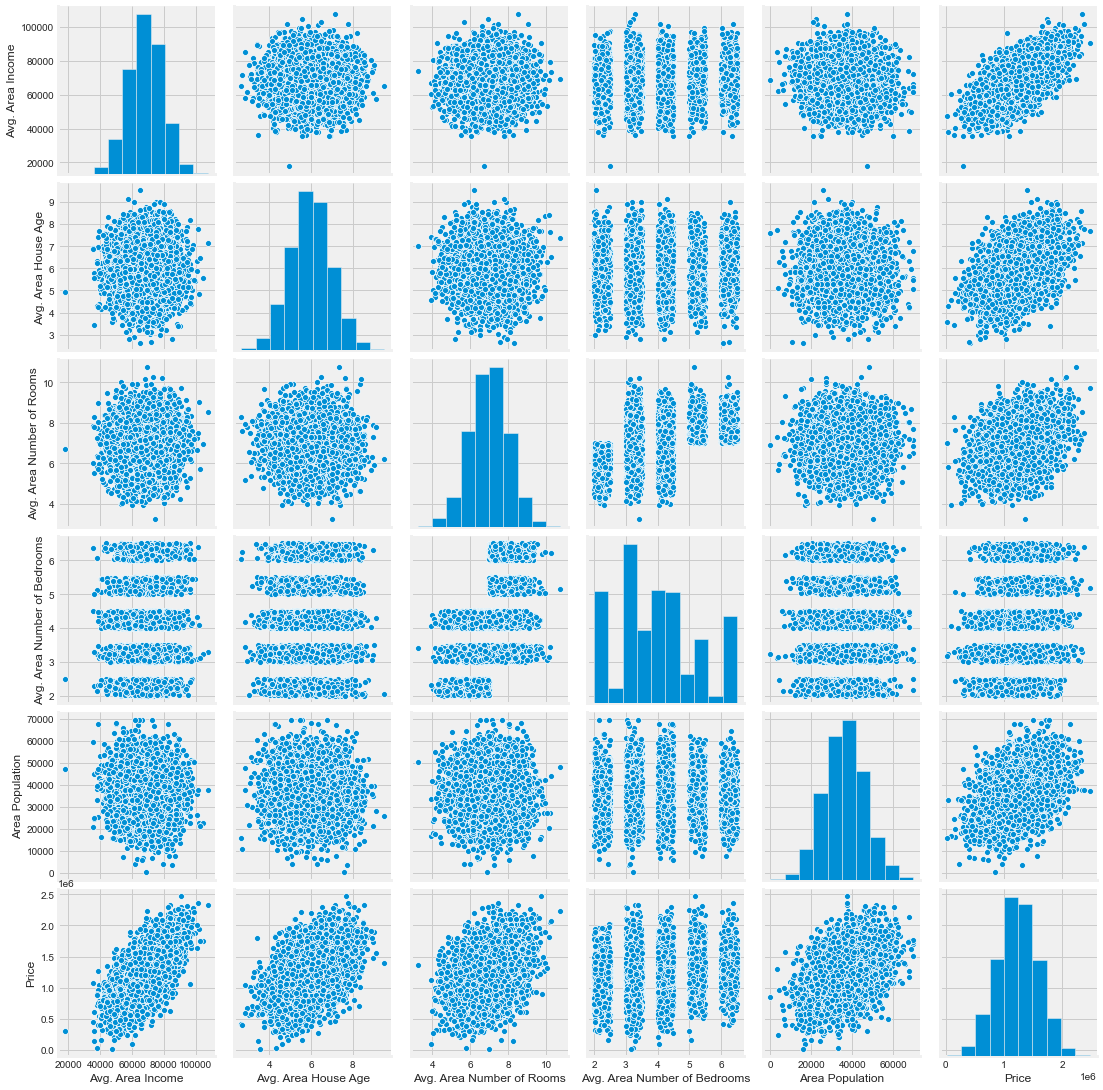

In [168]:
sns.pairplot(df)

#Outlier Analysis

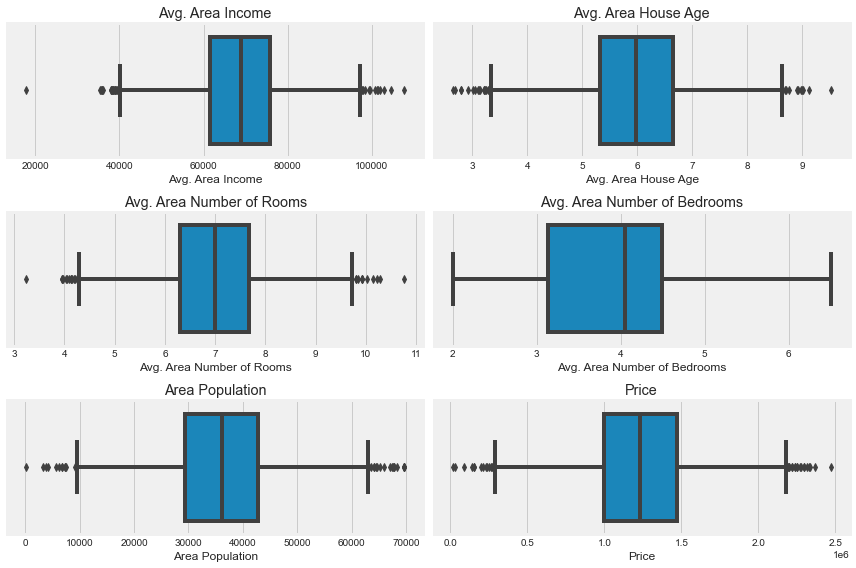

In [116]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, j in enumerate(df.columns):
    g = sns.boxplot(x = df[j], ax = axes_[i])
    g.set_title(j)
    plt.tight_layout()

Here we can some potential outliers present in our data except the Avg. Area Number of Bedrooms. Now we have to decide whether we should ignore this outliers or let it be in our model so before going into any conclusion, we will first investigate these extreme values first to make any conclusion.

In [117]:
df.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


In [118]:
col = df.columns

In [119]:
def check_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    outliers = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]

    print("Outliers Report")

    print(f"The total number of outliers in Data: {len(outliers)}")

    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.plot(data[col])
    plt.title(col + " with Outliers")
    plt.scatter(x=outliers.index, y=outliers.values, marker="X", color='r', s=100)

    plt.subplot(212)
    plt.title(col + " after removing Extreme Values")
    filter_data = data[col][-(data[col].isin(outliers))]
    sns.boxplot(filter_data)

Outliers Report
The total number of outliers in Data: 25


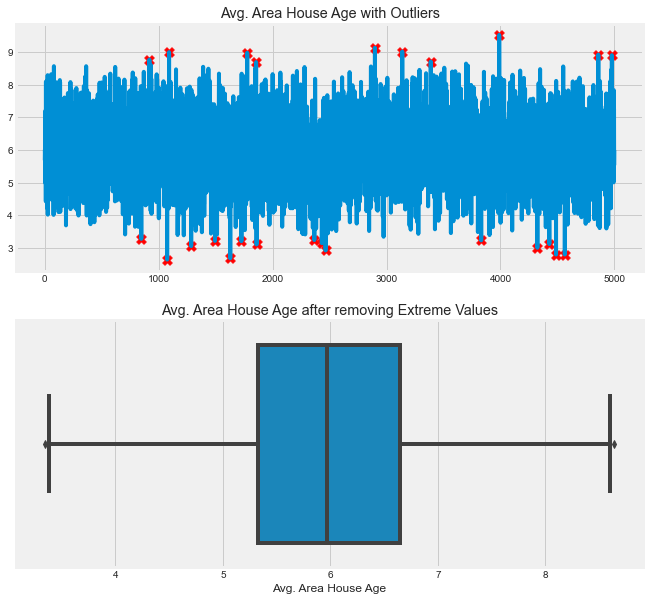

In [120]:
check_outliers(df, col[1])

Outliers Report
The total number of outliers in Data: 35


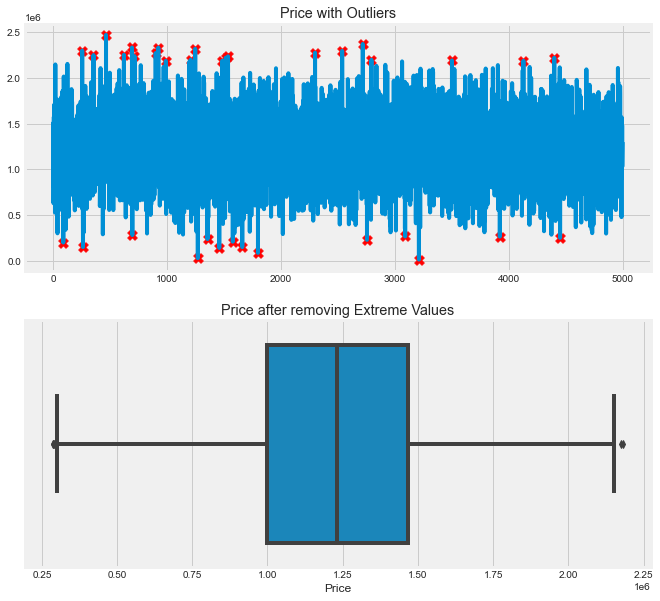

In [121]:
check_outliers(df, col[5])

After removing the outliers we can see our data become more stables so what we can do instead or removing or imputing we will apply technique called winsorization in which we cap the lower and upper extreme values using quantiles.

##Winsorization

In [122]:
df_copy = df.copy()

In [123]:
def apply_winsorize(data, col):
    winsorize(data[col], limits= [0.005, 0.005], inplace=True)

In [124]:
for i, j in df.items():
    apply_winsorize(df_copy, i)

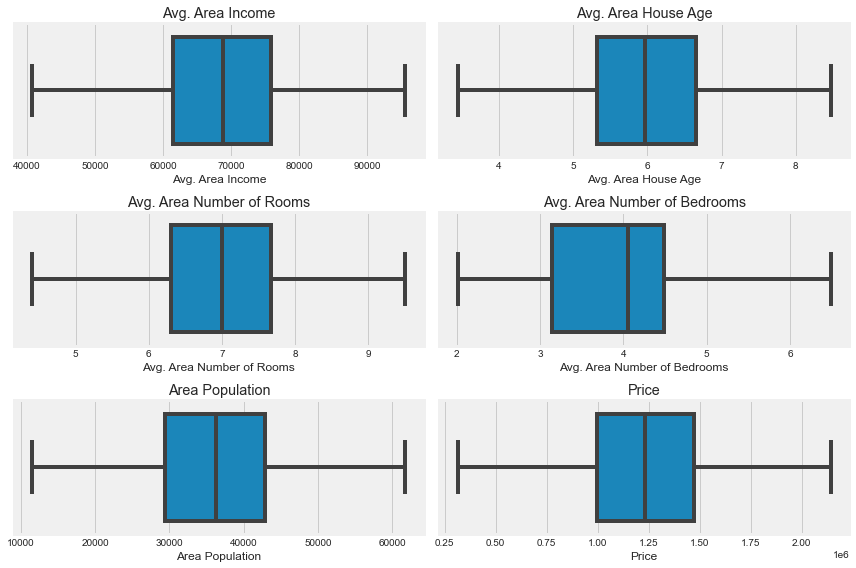

In [125]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, j in enumerate(df.columns):
    g = sns.boxplot(x = df_copy[j], ax = axes_[i])
    g.set_title(j)
    plt.tight_layout()

In [126]:
X = df_copy.drop('Price', axis=1)

In [127]:
y = df_copy['Price']

In [128]:
X.shape, y.shape

((5000, 5), (5000,))

In [129]:
X.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
0,79545.458574,5.682861,7.009188,4.09,23086.800503
1,79248.642455,6.002900,6.730821,3.09,40173.072174
2,61287.067179,5.865890,8.512727,5.13,36882.159400
3,63345.240046,7.188236,5.586729,3.26,34310.242831
4,59982.197226,5.040555,7.839388,4.23,26354.109472


In [130]:
y.head()

0    1059033.56
1    1505890.91
2    1058987.99
3    1260616.81
4     630943.49
Name: Price, dtype: float64

<AxesSubplot:xlabel='Price'>

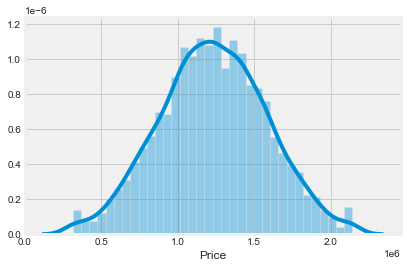

In [131]:
sns.distplot(y)

<AxesSubplot:>

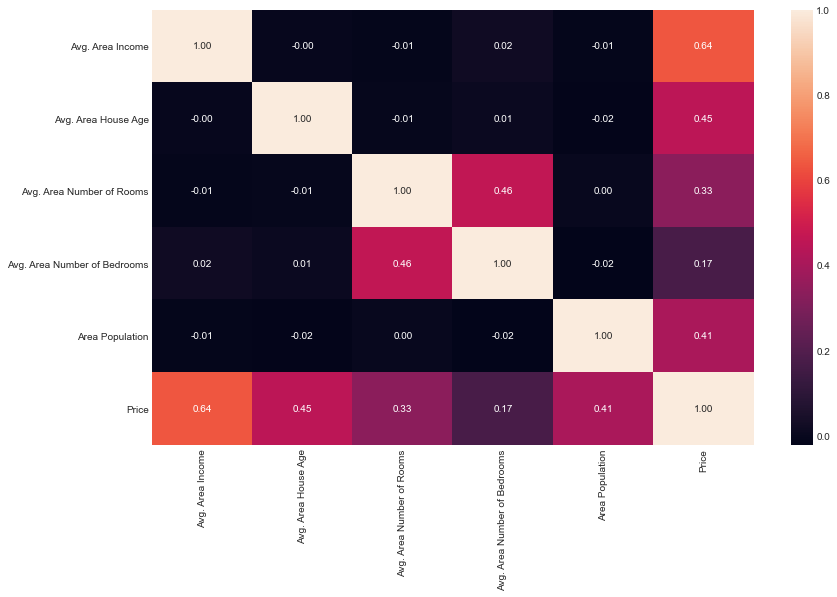

In [132]:
plt.figure(figsize=(12,8))
sns.heatmap(df_copy.corr(), annot=True, fmt='.2f')

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

#Sklearn Pipeline

In [134]:
# Testing Different Regression Algorithms to choose the best one

lr_pipeline = Pipeline([("scaler", StandardScaler()), ("linear_regression", LinearRegression())])
rb_pipeline = Pipeline([("scaler", StandardScaler()), ("robust_regression", RANSACRegressor(random_state=42))])
theil_pipeline = Pipeline([("scaler", StandardScaler()), ("theil_regressor", TheilSenRegressor(random_state=42))])
ridge_pipeline = Pipeline([("scaler", StandardScaler()), ("ridge_regressor", Ridge(random_state = 42))])
lasso_pipeline = Pipeline([("scaler", StandardScaler()), ("lasso_regressor", Lasso(random_state = 42))])
elastic_pipeline = Pipeline([("scaler", StandardScaler()), ("elastic_net", ElasticNet(random_state = 42))])
random_forest_pipeline = Pipeline([("scaler", StandardScaler()), ("randomforest_regression", RandomForestRegressor(random_state = 42))])
xgboost_pipeline = Pipeline([("scaler", StandardScaler()), ("xgboost_regression", XGBRegressor())])
adaboost_pipeline = Pipeline([("scaler", StandardScaler()), ("adaboost_regression", AdaBoostRegressor(random_state = 42))])
gradient_pipeline = Pipeline([("scaler", StandardScaler()), ("gradientboost_regression", GradientBoostingRegressor(random_state = 42))])
lightgbm_pipeline = Pipeline([("scaler", StandardScaler()), ("lightgbm_regression", LGBMRegressor(random_state = 42))])
catboost_pipeline = Pipeline([("scaler", StandardScaler()), ("catboost_regression", CatBoostRegressor(random_state = 42, silent = True))])
decisiontree_pipeline = Pipeline([("scaler", StandardScaler()), ("decisiontree_regression", DecisionTreeRegressor(random_state = 42))])
knn_pipeline = Pipeline([("scaler", StandardScaler()), ("knn_regression", KNeighborsRegressor())])
sgc_pipeline = Pipeline([("scaler", StandardScaler()), ("sgd_regression", SGDRegressor(random_state = 42))])

In [135]:
pipelines = [lr_pipeline, rb_pipeline, theil_pipeline, ridge_pipeline, lasso_pipeline, elastic_pipeline,
             random_forest_pipeline, xgboost_pipeline, adaboost_pipeline, gradient_pipeline, lightgbm_pipeline,
             catboost_pipeline, decisiontree_pipeline, knn_pipeline, sgc_pipeline]

In [136]:
pipe_dict = {0: "Linear Regression", 1: "Robust", 2: "Theil Sen", 3: "Ridge", 4: "Lasso", 5: "ElasticNet",
             6: "RandomForest", 7: "XGBoost", 8: "Adaboost", 9: "GradientBoost", 10: "LightGBM",
             11: "CatBoost", 12: "Decision Tree", 13: "KNN", 14: "SGD"}

In [137]:
for i, pipe in enumerate(pipelines):
    score = cross_val_score(pipe, X, y, cv=10)
    print(pipe_dict[i], ":", score.mean())

Linear Regression : 0.9149440641880741
Robust : 0.9052638307039592
Theil Sen : 0.914828789830306
Ridge : 0.9149441324435852
Lasso : 0.9149440550810283
ElasticNet : 0.8096503109985094
RandomForest : 0.8856027107846453
[13:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated i

Based on the above cross validation, we can see that **Linear Regression**, **Theil Sen Regressor**, **Ridge**, **Lasso**, **Stochastic Gradient Descent** works best among the all. But for our model, we will be going to choose **Linear**, **Ridge** & **Lasso** Regression Models to perform hyperparameter tuning to find the best model among three.

#Cross Validation - Randomized Search CV

In [138]:
pipeline_new = Pipeline([("scaler", StandardScaler()), ("classifier", LinearRegression())])

In [139]:
grid_params = [
    {"classifier": [LinearRegression()],
    "classifier__normalize": [True, False]
     },
    {"classifier": [Ridge()],
     "classifier__alpha": np.arange(0.5, 5, 0.25),
     "classifier__fit_intercept": [True, False],
     "classifier__max_iter": [50, 100, 500, 1000, 2500],
     "classifier__tol": [0.001, 0.01, 0.05, 0.1, 1, 5, 10],
     "classifier__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg,", "sag", "saga"]
    },
    {"classifier": [Lasso()],
    "classifier__alpha": np.arange(0.5, 5, 0.25),
    "classifier__fit_intercept": [True, False],
    "classifier__max_iter": [50, 100, 500, 1000, 2500],
    "classifier__tol": [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10],
    "classifier__warm_start": [True, False],
    "classifier__positive": [True, False],
    "classifier__selection": ["cyclic", "random"]
     }
]

In [140]:
random_search = RandomizedSearchCV(estimator = pipeline_new, param_distributions = grid_params,
                                   scoring = 'neg_mean_absolute_error', n_jobs= -1, cv = 8, verbose = 10, random_state = 42)

In [141]:
best_model = random_search.fit(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


In [142]:
best_model.best_params_

{'classifier__warm_start': True,
 'classifier__tol': 0.1,
 'classifier__selection': 'cyclic',
 'classifier__positive': False,
 'classifier__max_iter': 1000,
 'classifier__fit_intercept': True,
 'classifier__alpha': 1.5,
 'classifier': Lasso(alpha=1.5, tol=0.1, warm_start=True)}

In [143]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()), ('lasso_reg', Lasso(alpha=1.5, tol=0.1, warm_start=True))])

In [144]:
model = pipeline_lasso.fit(X_train, y_train)

In [145]:
y_pred = model.predict(X_test)

#Prediction Diagnosis

In [146]:
def print_evaluate(true, prediction):
    mae = mean_absolute_error(true, prediction)
    mse = mean_squared_error(true, prediction)
    rmse = np.sqrt(mean_squared_error(true, prediction))
    r2_square = r2_score(true, prediction)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R2 Square: {r2_square}")

In [147]:
def plot_diag(true, prediction):
    
    #residuals
    resid = (true-prediction)
    
    #plotting the distplot
    plt.figure(figsize=(14,8))
    plt.subplot(221)
    plt.title("Distplot")
    sns.distplot(resid)
    
    #plotting the residual plot
    plt.subplot(222)
    plt.title("Residual Plot")
    sns.scatterplot(x = prediction, y = resid)
    sns.lineplot(x = [min(prediction), max(prediction)], y = [0,0], linestyle = '--', color = 'r')
    
    #plotting the quantile plot
    ax = plt.subplot(223)
    plt.title("Quantile Plot")
    sm.qqplot(resid, line = 'r', ax = ax)
    
    #plotting the autocorrelation plot
    ax2 = plt.subplot(224)
    plt.title("Autocorrelation Plot")
    plot_acf(resid, ax = ax2)
    plt.tight_layout()

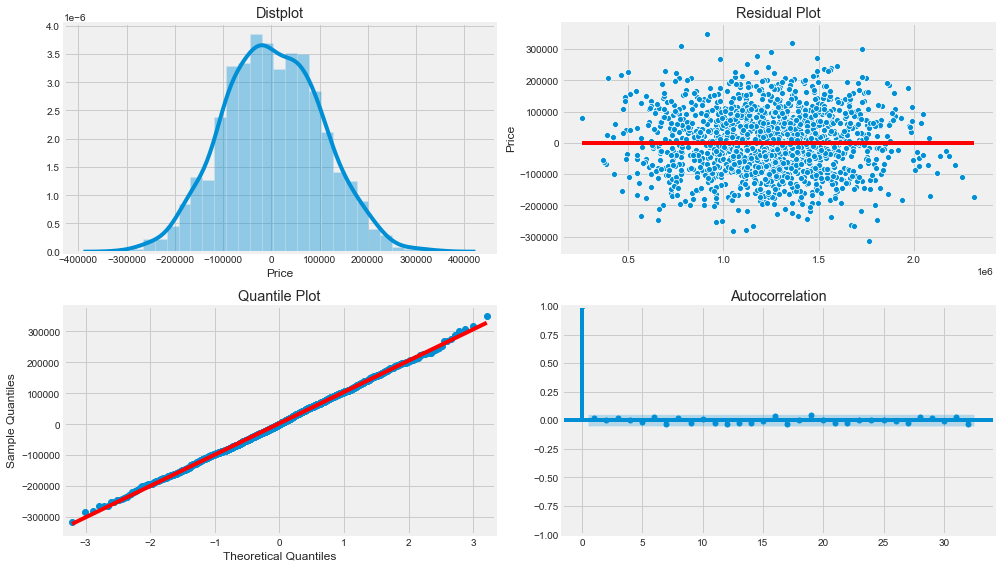

In [148]:
plot_diag(y_test, y_pred)

<AxesSubplot:xlabel='Price'>

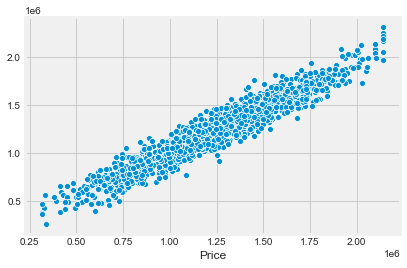

In [149]:
sns.scatterplot(x = y_test, y = y_pred)

In [150]:
print_evaluate(y_test, y_pred)

MAE: 81652.49150020046
MSE: 10212895325.94552
RMSE: 101058.87059504238
R2 Square: 0.912360839689509


In [151]:
X_test["Predicted Price"] = y_pred
X_test["Original Price"] = y_test
X_test["Predicted Price"] = rounder(X_test["Predicted Price"])

In [152]:
X_test

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Predicted Price,Original Price
1501,61907.593345,7.017838,6.440256,3.25,43828.947207,1307474.41,1339096.08
2586,57160.202243,6.893260,6.921532,3.13,43467.147035,1236878.54,1251794.18
2653,70190.796445,6.745054,6.662567,2.01,29215.136112,1245424.05,1340094.97
1055,69316.796889,6.300409,7.873576,4.28,24448.211461,1231336.67,1431507.62
705,72991.481649,3.443458,6.494081,2.48,50626.495426,1063332.22,1042373.52
...,...,...,...,...,...,...,...
3563,74208.124644,6.259782,8.666717,3.38,25507.336340,1441223.00,1348221.77
1538,71112.350296,5.612677,7.419542,4.26,24134.413996,1096404.47,1309937.40
1837,63665.394418,6.729105,7.732959,3.43,44029.681816,1457842.57,1472887.25
2380,56073.892443,6.576733,6.959056,4.40,61772.756810,1444412.20,1409762.12
